In [135]:
import torch
import numpy as np
import pickle
from utils import groundtruth
from utils import pde_VPINN as pde
from utils import model,tools,validation
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm

In [136]:
dtype = torch.float64


resolution = 128
val_x1=np.arange(-1,1,2/resolution).reshape(-1,1)
val_x2=np.arange(-1,1,2/resolution).reshape(-1,1)
t_vx1 = torch.from_numpy(val_x1).type(dtype)
t_vx2 = torch.from_numpy(val_x2).type(dtype)



#Generate grids to output graph
val_ms_x1, val_ms_x2 = np.meshgrid(val_x1, val_x2)

plot_val_x1 = np.ravel(val_ms_x1).reshape(-1,1)
plot_val_x2 = np.ravel(val_ms_x2).reshape(-1,1)

mark = np.logical_and(val_ms_x1>0.0,val_ms_x2<0)

t_val_vx1,t_val_vx2 = tools.from_numpy_to_tensor([plot_val_x1,plot_val_x2],[False,False],dtype=dtype)

In [137]:
np.ravel(val_ms_x1).shape

(16384,)

In [138]:
y_net = torch.load("results/VPINN_t10/u_net.pt")
y_b = torch.load("results/VPINN_t10/ub.pt")
y_hom = torch.load("results/VPINN_t10/ubh.pt")

def y_vpinn_pre(qp):
    return y_net(qp,y_b,y_hom)

def y_vpinn(x1,x2):
    return y_vpinn_pre(torch.concatenate([x1,x2],axis=1).unsqueeze(1))

#y_drm = torch.load("/Users/dual/Documents/projects/ReviewArticle/Poisson_Ldomain/results/y.pt")
#y_pinn = torch.load("results/PINN_t10/y.pt")
#y_drm = torch.load("results/DRM_t10/y.pt")
#y_vpinn = torch.load("results/VPINN_t10/u_net.pt")





/var/folders/f8/v3yx4y7d3cl0lsv61lxg351c0000gn/T/ipykernel_7990/3789123261.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  y_net = torch.load("results/VPINN_t10/u_net.pt

In [139]:
#validation.validate(y_pinn)
#validation.validate(y_drm)

In [140]:
sns.set_theme(style='white')
def plot_2D_data(fig,ax,data,title="",xlabel="",ylabel="",barlabel="",format=None,titlefs=25,labelfs=45,normminmax=None,is_colorbar = True):
    mpl.rcParams['font.size'] = titlefs
    plot_data = data.copy()
    plot_data[mark] = np.nan
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_axis_off()
    mpl.rcParams['font.size'] = labelfs
    if is_colorbar:
        if normminmax is not None:
            #im = ax.imshow(plot_data,cmap=cm.coolwarm,norm=mpl.colors.Normalize(vmin=normminmax[0], vmax=normminmax[1]))
            im = ax.pcolor(val_ms_x1,val_ms_x2,plot_data, cmap='jet',norm=mpl.colors.Normalize(vmin=normminmax[0], vmax=normminmax[1]))
            cbar = fig.colorbar(im, ax=ax, label=barlabel,shrink=1.,pad=0.03,format=format,spacing="proportional",norm=mpl.colors.Normalize(vmin=normminmax[0], vmax=normminmax[1]))        
            #cbar = fig.colorbar(im, ax=ax, label=barlabel,shrink=0.82,pad=0.03,format=format,spacing="proportional",norm=mpl.colors.Normalize(vmin=normminmax[0], vmax=normminmax[1]))
        else:
            #im = ax.imshow(plot_data,cmap=cm.coolwarm)
            im = ax.pcolor(val_ms_x1,val_ms_x2,plot_data, cmap='jet')
            cbar = fig.colorbar(im, ax=ax, label=barlabel,shrink=1.,pad=0.03,format=format,spacing="proportional")
        cbar.ax.tick_params(labelsize=labelfs)

def plot_2D_func(net,*args,**kwargs):
    pt_u = net(t_val_vx1,t_val_vx2).detach().numpy().reshape([resolution,resolution])
    plot_2D_data(data=pt_u,*args,**kwargs)

def plot_err(net,data,*args,**kwargs):
    pt_u = net(t_val_vx1,t_val_vx2).detach().numpy().reshape([resolution,resolution])
    err = np.abs(pt_u-data)
    plot_2D_data(data = err,*args,**kwargs)

/var/folders/f8/v3yx4y7d3cl0lsv61lxg351c0000gn/T/ipykernel_7990/1566801643.py:15: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(im, ax=ax, label=barlabel,shrink=1.,pad=0.03,format=format,spacing="proportional",norm=mpl.colors.Normalize(vmin=normminmax[0], vmax=normminmax[1]))


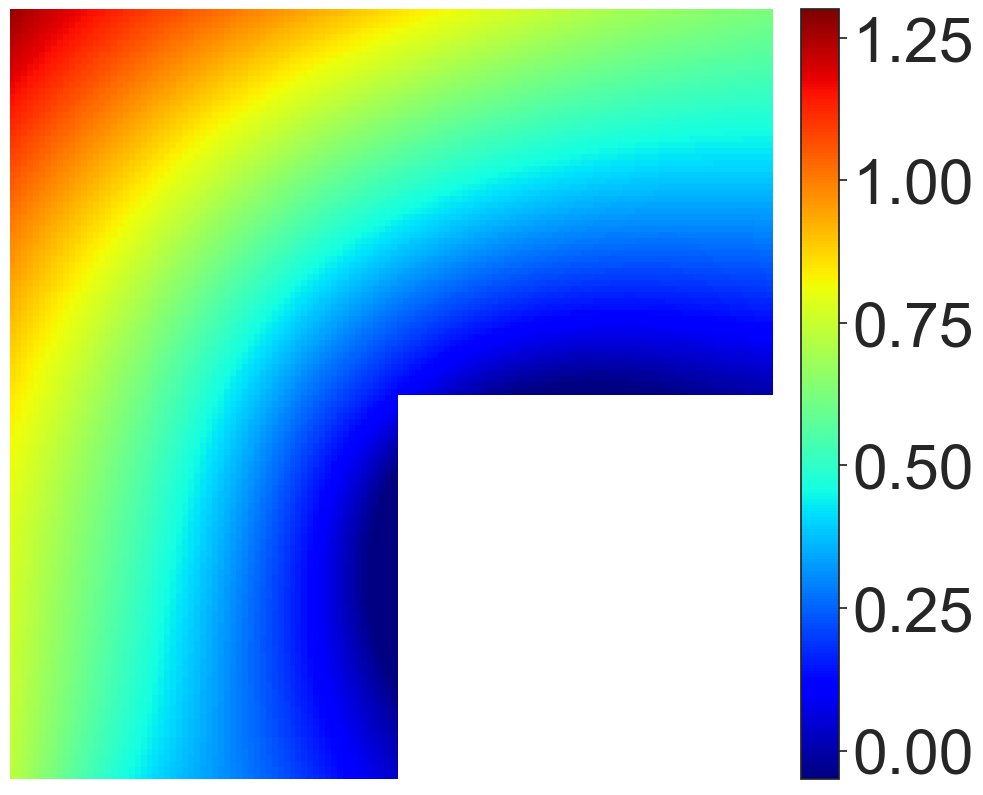

In [141]:
vmin = -0.05
vmax = 1.30

fig, ax = plt.subplots(1,1,figsize=[12,10])
plot_2D_func(fig=fig,ax=ax,net = y_vpinn,format="%.2f",normminmax=[vmin,vmax])
plt.savefig("figures/y_vpinn",dpi=300,bbox_inches="tight")
#plt.close()

# fig, ax = plt.subplots(1,1,figsize=[12,10])
# plot_2D_func(fig=fig,ax=ax,net = y_drm,format="%.2f",normminmax=[vmin,vmax])
# plt.savefig("figures/y_drm",dpi=300,bbox_inches="tight")
# #plt.close()

# fig, ax = plt.subplots(1,1,figsize=[12,10])
# plot_2D_func(fig=fig,ax=ax,net = y_pinn,format="%.2f",normminmax=[vmin,vmax])
# plt.savefig("figures/y_pinn",dpi=300,bbox_inches="tight")
# #plt.close()

/var/folders/f8/v3yx4y7d3cl0lsv61lxg351c0000gn/T/ipykernel_7990/1566801643.py:15: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(im, ax=ax, label=barlabel,shrink=1.,pad=0.03,format=format,spacing="proportional",norm=mpl.colors.Normalize(vmin=normminmax[0], vmax=normminmax[1]))


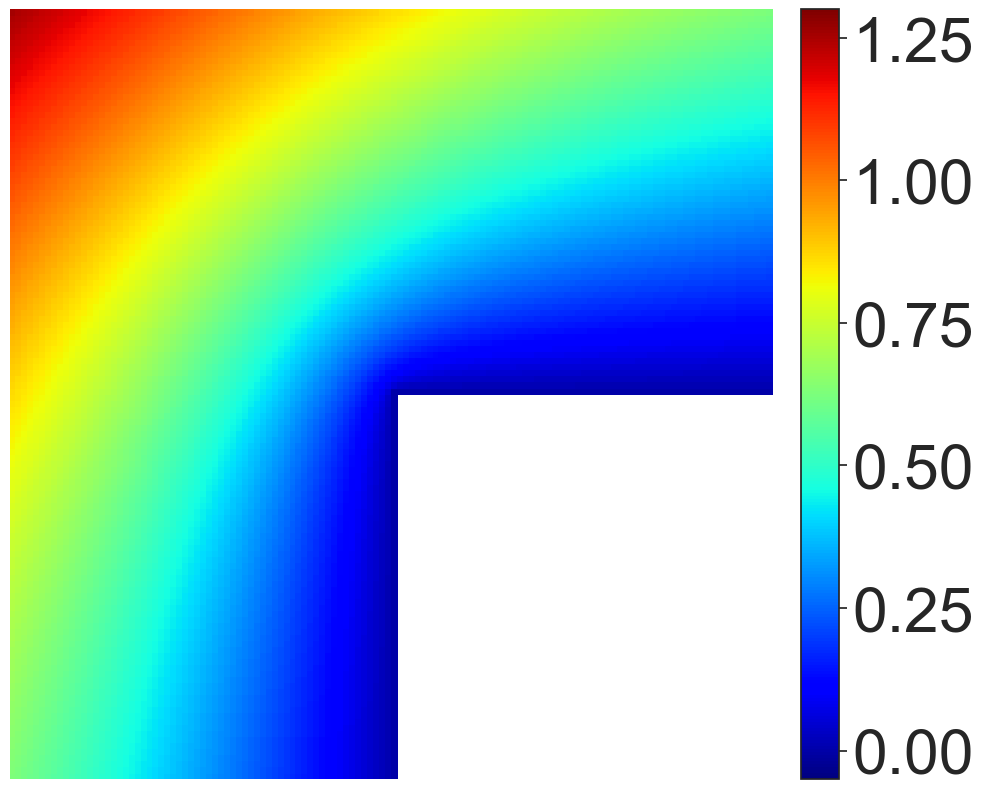

In [142]:
gtgen = groundtruth.gt_gen()
ygt = gtgen.generate_by_cart(gtgen.y,np.concatenate([plot_val_x1,plot_val_x2],1)).reshape([resolution,resolution])

ygt[mark] = np.nan


fig, ax = plt.subplots(1,1,figsize=[12,10])
plot_2D_data(fig=fig,ax=ax,data = ygt,format="%.2f",normminmax=[vmin,vmax])
plt.savefig("figures/gt",dpi=300,bbox_inches="tight")

In [143]:
# vmax = 0.42
# vmin = 0.01

# fig, ax = plt.subplots(1,1,figsize=[12,10])
# plot_2D_data(fig=fig,ax=ax,data = np.abs(ygt-y_pinn(t_val_vx1,t_val_vx2).detach().numpy().reshape(resolution,resolution)),format="%.2f",normminmax=[vmin,vmax])
# plt.savefig("figures/pinn_err",dpi=300,bbox_inches="tight")

# fig, ax = plt.subplots(1,1,figsize=[12,10])
# plot_2D_data(fig=fig,ax=ax,data = np.abs(ygt-y_drm(t_val_vx1,t_val_vx2).detach().numpy().reshape(resolution,resolution)),format="%.2f",normminmax=[vmin,vmax])
# plt.savefig("figures/drm_err",dpi=300,bbox_inches="tight")

/var/folders/f8/v3yx4y7d3cl0lsv61lxg351c0000gn/T/ipykernel_7990/1566801643.py:15: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(im, ax=ax, label=barlabel,shrink=1.,pad=0.03,format=format,spacing="proportional",norm=mpl.colors.Normalize(vmin=normminmax[0], vmax=normminmax[1]))


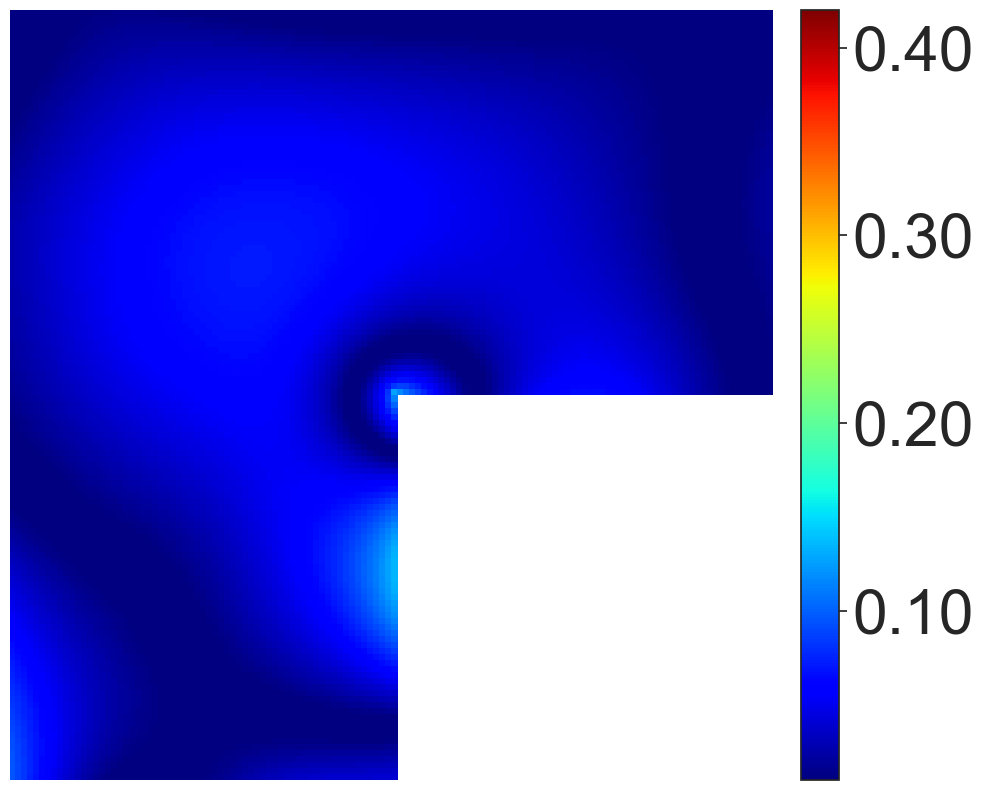

In [144]:
vmax = 0.42
vmin = 0.01

fig, ax = plt.subplots(1,1,figsize=[12,10])
plot_2D_data(fig=fig,ax=ax,data = np.abs(ygt-y_vpinn(t_val_vx1,t_val_vx2).detach().numpy().reshape(resolution,resolution)),format="%.2f",normminmax=[vmin,vmax])
plt.savefig("figures/vpinn_err",dpi=300,bbox_inches="tight")

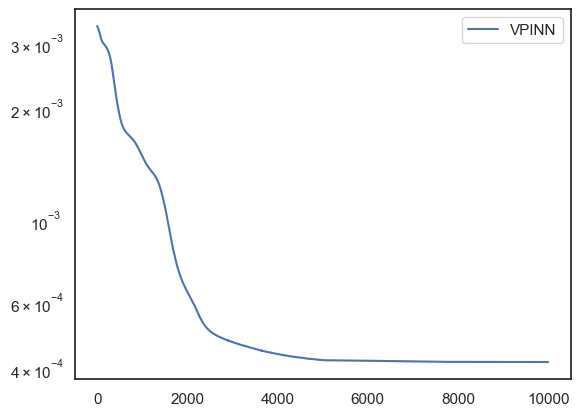

In [145]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

# with open("results/PINN_t10/losshist.pkl", 'rb') as pfile:
#     losshist = pkl.load(pfile)

# plt.plot(losshist, label='PINN')
# plt.yscale('log')
# plt.legend()
# plt.savefig("figures/pinn_loss",dpi=300,bbox_inches="tight")


# with open("results/DRM_t10/losshist.pkl", 'rb') as pfile:
#     losshist = pkl.load(pfile)

# plt.plot(losshist, label='DRM')
# plt.yscale('log')
# plt.legend()
# plt.savefig("figures/drm_loss",dpi=300,bbox_inches="tight")


with open("results/VPINN_t10/losshist.pkl", 'rb') as pfile:
    losshist = pkl.load(pfile)

plt.plot(losshist, label='VPINN')
plt.yscale('log')
plt.legend()
plt.savefig("figures/vpinn_loss",dpi=300,bbox_inches="tight")
